In [1]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from gerrychain import Graph
from networkx import DiGraph
import gurobipy as gp
from gurobipy import GRB
import math
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import requests





In [2]:
state = "AR"
level = "census_tracts" #census_tracts or counties
base_url = 'https://lykhovyd.com/files/public/districting/2020/{}/{}/'.format(state, level)
filepath = '' #to save the files

if level == "counties":
  filename = state + "_counties"
elif level == "census_tracts":
  filename = state + "_tracts"


#Download shapefiles for map
url_maps = base_url + "maps/"
for fx in {'.shp', '.shx', '.dbf', '.prj', '.cpg'}:
  myfile = requests.get(url_maps+filename+fx, verify=False)
  open(filepath+filename+fx, 'wb').write(myfile.content)

#Download graph files
url_graph = base_url + "graph/"
for fx in {'.dimacs', '.hash', '.population', '_distances.csv'}:
  myfile = requests.get(url_graph+state+fx, verify=False)
  open(filepath+filename+fx, 'wb').write(myfile.content)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lykhovyd.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/var/folders/wq/f62mjvzd5hg0kcxbnmfj4cx80000gn/T/ipykernel_35070/3101945887.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='AR_tracts.cpg'>
  open(filepath+filename+fx, 'wb').write(myfile.content)
/var/folders/wq/f62mjvzd5hg0kcxbnmfj4cx80000gn/T/ipykernel_35070/3101945887.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='AR_tracts.shp'>
  open(filepath+filename+fx, 'wb').write(myfile.content)
/var/folders/wq/f62mjvzd5hg0kcxbnmfj4cx80000gn/T/ipykernel_35070/3101945887.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='AR_tracts.dbf'>
  open(filepath+filename+fx, 'wb').write(myfile.content)
/var/folders/wq

In [3]:
def read_edges(filename):
  with open(filename, 'r') as file:
    edges = []
    for line in file:
      parts = line.strip().split()
      if parts[0] == 'e':
        edge = (int(parts[1]), int(parts[2]))
        edges.append(edge)
  return edges

def read_dists(filename):
    df = pd.read_csv(filename, index_col=0)
    return df.values.tolist()


def read_population(filename):
    with open(filename, 'r') as file:
        total_population = int(file.readline().strip().split('=')[-1])
        data = []
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                identifier, population = int(parts[0]), int(parts[1])
                data.append((identifier, population))
            else:
                print(f"Unexpected line format: {line}")
    return total_population, data

def read_geoids(filename):
  with open(filename, 'r') as file:
    data = []
    for line in file:
      parts = line.strip().split()
      if len(parts) == 2:
          identifier, population = int(parts[0]), int(parts[1])
          data.append((identifier, population))
      else:
          print(f"Unexpected line format: {line}")
  return  data


def read_num_districts(filename):
  with open(filename, 'r') as file:
    lines = [line for line in file]
  return  int(lines[-1][-2])


def draw_graph(Graph, node_size = 1100, node_label_font_size = 9, show_districts = False):

  total_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes )
  ideal_population = total_population / k

  elarge = [(u, v) for (u, v, d) in G.edges(data=True)]

  pos = nx.spring_layout(G, seed=7, scale = 0.01)

  if show_districts:
    #obtain districts
    distrs = [G.nodes[i]['DISTR'] for i in range(len(G.nodes))]
    if distrs[0] is not None:
      # nodes
      nx.draw_networkx_nodes(G, pos, node_size=1100, node_color=distrs, cmap = 'tab20c')
    else:
      nx.draw_networkx_nodes(G, pos, node_size=1100)

  else:
    nx.draw_networkx_nodes(G, pos, node_size=1100)



  # edges
  nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5)

  pop_dict = {node:pop for node, pop in population}
  # node labels
  nx.draw_networkx_labels(G, pos, labels =pop_dict,  font_size=9, font_family="sans-serif")
  # edge weight labels
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)

  ax = plt.gca()
  ax.margins(0.08)
  plt.title("State: {}".format(state))
  plt.axis("off")
  plt.tight_layout()
  plt.show()


def draw_map(k,districts = None):
  # Load the Shapefile
  gdf = gpd.read_file('{}.shp'.format(filename))

  if districts is None:
    # Plot the Shapefile
    fig, ax = plt.subplots(figsize=(10, 10))
    my_fig = gdf.plot(ax=ax).get_figure()
    plt.show()


  else: #draw districts
    # Which district is each county assigned to?
    labeling = { i : -1 for i in G.nodes}

    for j in range(k):
        district = districts[j]
        for i in district:
            labeling[i] = j

    #Store district info in nodes
    for node in G.nodes:
      G.nodes[node]['DISTR'] = labeling[node]

    geoid_to_district = { G.nodes[i]['GEOID20'] : labeling[i] for i in G.nodes }

    assignments = []

    for i in range(len(gdf)):
      geoid = int(gdf['GEOID20'][i])
      assignments.append(geoid_to_district[geoid])

    gdf['assignment'] = assignments
    fig, ax = plt.subplots(figsize=(10, 10))
    my_fig = gdf.plot(column='assignment', ax= ax).get_figure()
    plt.show()

In [4]:
def read_matrix(filename):
    df = pd.read_csv(filename, index_col=0)
    edges = []
    
    for i, row in df.iterrows():
        for j, value in row.items():
            if value != 0:
                edges.append((int(i), int(j), int(value)))

    return edges

In [5]:
def read_population(filename):
    with open(filename, 'r') as file:
        total_population = int(file.readline().strip().split('=')[-1])
        data = []
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                identifier, population = int(parts[0]), int(parts[1])
                data.append((identifier, population))
            else:
                print(f"Unexpected line format: {line}")
    return total_population, data

In [52]:
RI = 2
AK =3
# Sklearn K means Clustering 
edges = read_matrix('data/RI_distances.csv')
print(edges)
total_population, population = read_population('data/RI.population')
G = Graph()
G.add_weighted_edges_from(edges)
for (node, pop) in population:
    #print(node)
    G.nodes[node]['pop'] = pop
    G.nodes[node]['name'] = node
edge_weights = nx.to_numpy_array(G=G)
populations = np.array([G.nodes[node]['pop'] for node in G.nodes])
# Define weights for features (edges and population)
edge_weight_weight = 1.0  # Adjust as needed
population_weight = 10.0    # Adjust as needed
# Adjust weights of population feature to balance with edge weights
data = np.column_stack((edge_weights, populations))
data_normalized = (data - data.mean(axis=0)) / data.std(axis=0)
data_normalized[:, -1] *= (edge_weight_weight / population_weight)
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(data_normalized)
# Get cluster labels
cluster_labels = kmeans.labels_



[(0, 1, 2), (0, 2, 4), (0, 3, 15), (0, 4, 12), (0, 5, 17), (0, 6, 2), (0, 7, 5), (0, 8, 14), (0, 9, 14), (0, 10, 27), (0, 11, 9), (0, 12, 12), (0, 13, 19), (0, 14, 17), (0, 15, 13), (0, 16, 5), (0, 17, 11), (0, 18, 7), (0, 19, 8), (0, 20, 9), (0, 21, 30), (0, 22, 23), (0, 23, 9), (0, 24, 11), (0, 25, 10), (0, 26, 12), (0, 27, 4), (0, 28, 14), (0, 29, 17), (0, 30, 2), (0, 31, 13), (0, 32, 4), (0, 33, 29), (0, 34, 17), (0, 35, 54), (0, 36, 36), (0, 37, 41), (0, 38, 35), (0, 39, 55), (0, 40, 32), (0, 41, 66), (0, 42, 32), (0, 43, 26), (0, 44, 19), (0, 45, 59), (0, 46, 28), (0, 47, 25), (0, 48, 8), (0, 49, 4), (0, 50, 8), (0, 51, 6), (0, 52, 10), (0, 53, 12), (0, 54, 11), (0, 55, 14), (0, 56, 16), (0, 57, 14), (0, 58, 12), (0, 59, 2), (0, 60, 5), (0, 61, 4), (0, 62, 14), (0, 63, 15), (0, 64, 15), (0, 65, 14), (0, 66, 24), (0, 67, 13), (0, 68, 12), (0, 69, 53), (0, 70, 38), (0, 71, 47), (0, 72, 43), (0, 73, 14), (0, 74, 57), (0, 75, 43), (0, 76, 22), (0, 77, 27), (0, 78, 12), (0, 79, 9), (0

In [53]:
# Sklearn clustering
# Print cluster assignments and calculate total distance within clusters
total_distance_within_clusters = 0
for i in range(num_clusters):
    cluster_nodes = np.where(cluster_labels == i)[0]  # Retrieve node indices in this cluster
    print(f"Cluster {i+1}:", cluster_nodes)
    # Calculate and print population of the cluster
    cluster_population = np.sum(populations[cluster_nodes])
    print(f"Population of Cluster {i+1}: {cluster_population}")

Cluster 1: [ 10  21  33  35  36  37  38  39  40  41  42  43  44  45  46  47  69  70
  71  72  74  75  76  77 181 188 197 198 207 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 233 234 235 236 237 238 239]
Population of Cluster 1: 208976
Cluster 2: [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  73
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 182 183 184 185 186
 187 189 190 191 192 193 194 195 196 199 200 201 202 203 204 205 206 208


In [54]:
# Custom kmeans class that minimizes population between clusters
class CustomKMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4, random_state=None, penalty_weight=1.0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.penalty_weight = penalty_weight

    def fit(self, X, population):
        np.random.seed(self.random_state)
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        self.labels = np.zeros(X.shape[0])
        self.old_labels = np.ones(X.shape[0])

        # Extract population values from the list of tuples
        #print(population)
        population_values = np.array([pop[1] for pop in population], dtype=float)
        #print(population_values)

        for _ in range(self.max_iter):
            self.old_labels[:] = self.labels
            self.update_labels(X)
            self.update_centroids(X, population_values)

            # Check for convergence
            if np.all(self.labels == self.old_labels):
                break
        #population_values = population_values*8281
        #print(population_values)
        # Calculate total population per cluster
        cluster_populations = [np.sum(population_values[self.labels == i]) for i in range(self.n_clusters)]
        print("Total population per cluster:", cluster_populations)
        districts = []
        # Print nodes for each cluster
        for i in range(self.n_clusters):
            cluster_nodes = np.where(self.labels == i)[0]
            print(f"Nodes in Cluster {i+1}: {cluster_nodes}")
            districts.append(cluster_nodes)
        return districts

    def update_labels(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        self.labels = np.argmin(distances, axis=1)
        
    def update_centroids(self, X, population):
        for i in range(self.n_clusters):
            mask = self.labels == i
            if np.sum(mask) > 0:
                ideal_population = np.sum(population) / self.n_clusters
                cluster_population = np.sum(population[mask])
                # Calculate the absolute difference between cluster population and ideal population
                population_difference = np.abs(cluster_population - ideal_population)
                #print(population_difference)
                # Scale penalty based on the population imbalance
                penalty_factor = np.log(1 + population_difference)
                # Adjust penalty weight based on the penalty factor
                #penalty_factor = population_difference
                weighted_penalty = self.penalty_weight * penalty_factor
                # Update centroids with weighted penalty
                #self.centroids[i] = np.average(X[mask], axis=0, weights=population[mask]) + weighted_penalty
                if np.any(population[mask]):
                    self.centroids[i] = np.average(X[mask], axis=0, weights=population[mask]) + weighted_penalty
                else:
                    self.centroids[i] = np.mean(X[mask], axis=0)  # Use unwei
    

In [48]:
# Test custom Kmeans
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
population = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 40)]
custom_kmeans = CustomKMeans(n_clusters=2, random_state=0,penalty_weight=0.4)
dist = custom_kmeans.fit(X, population)

Total population per cluster: [50.0, 30.0]
Nodes in Cluster 1: [3 4]
Nodes in Cluster 2: [0 1 2]


In [55]:
state = "RI"
filename = state + "_tracts"
#read files for graph
edges = read_edges('{}.dimacs'.format(filename))
total_population, population = read_population('{}.population'.format(filename))
geoids = read_geoids('{}.hash'.format(filename))

k = read_num_districts('{}.dimacs'.format(filename))  # desired number of districts
dists = read_dists('{}_distances.csv'.format(filename))
#populate graph
G=nx.Graph()

for (node, pop), (_, geoid) in zip(population, geoids):
  G.add_node(node, TOTPOP = pop, GEOID20 = geoid, DISTR = None)

#G.nodes gives a list of nodes
#for every node, node['TOTPOP'] gives population
#                node['GEOID20'] gives geoid20
#                node['DISTR'] gives assigned district
#edges are not weighted
#all distances are in dists
G.add_edges_from(edges)

In [56]:
edge_weights_sc = edge_weights/(np.sum(edge_weights) + 1e-7)
print(edge_weights_sc)


[[0.00000000e+00 1.30698965e-06 2.61397930e-06 ... 5.88145342e-06
  7.18844307e-06 3.92096895e-06]
 [1.30698965e-06 0.00000000e+00 2.61397930e-06 ... 7.18844307e-06
  8.49543272e-06 5.22795860e-06]
 [2.61397930e-06 2.61397930e-06 0.00000000e+00 ... 5.22795860e-06
  7.18844307e-06 4.57446377e-06]
 ...
 [5.88145342e-06 7.18844307e-06 5.22795860e-06 ... 0.00000000e+00
  1.96048447e-06 1.96048447e-06]
 [7.18844307e-06 8.49543272e-06 7.18844307e-06 ... 1.96048447e-06
  0.00000000e+00 2.61397930e-06]
 [3.92096895e-06 5.22795860e-06 4.57446377e-06 ... 1.96048447e-06
  2.61397930e-06 0.00000000e+00]]


In [12]:
pop_kmeans = np.array([(i,G.nodes[node]['TOTPOP']) for i,node in enumerate(G.nodes)])
#print(pop_kmeans)
scale = np.sum(pop_kmeans[:,1])
pop_kmeans_sc = [[arr[0], arr[1] / (scale + 1e-5)] for arr in pop_kmeans]
print(pop_kmeans_sc)



[[0, 0.004270174661586652], [1, 0.004213676405287383], [2, 0.004902590627259109], [3, 0.003503803152753025], [4, 0.004658372358094529], [5, 0.006265838876028556], [6, 0.002206165782266599], [7, 0.0], [8, 0.004958177621360002], [9, 0.005860327197751548], [10, 0.005948719630993952], [11, 0.003141120797799656], [12, 0.002973448553298601], [13, 0.006400705681388101], [14, 0.0032003528406940505], [15, 0.00460005157739851], [16, 0.0037133934583793438], [17, 0.002080411598890808], [18, 0.00383823637955676], [19, 0.005092133164521171], [20, 0.003918427453013786], [21, 0.0017259306037228164], [22, 0.004187249801534499], [23, 0.0014306816514492195], [24, 0.006086320222948622], [25, 0.0041134375634661], [26, 0.005666228349497609], [27, 0.00370245831199884], [28, 0.006248524894259425], [29, 0.006188381589166656], [30, 0.003332485859458469], [31, 0.003272342554365699], [32, 0.003537519854092911], [33, 0.005886753801504432], [34, 0.005429300177920032], [35, 0.005699945050837495], [36, 0.007308322830

In [57]:
# Custom Kmeans on RI
pop_kmeans = np.array([(i,G.nodes[node]['TOTPOP']) for i,node in enumerate(G.nodes)])
custom_kmeans = CustomKMeans(n_clusters=2, random_state=0,penalty_weight=0.7)
dist = custom_kmeans.fit(edge_weights, pop_kmeans)

Total population per cluster: [138760.0, 958619.0]
Nodes in Cluster 1: [ 35  36  37  38  39  40  41  42  45  46  69  70  71  72  74  75 197 198
 207 217 218 219 220 223 224 225 229 230 231 233 234 235 236 237 238 239]
Nodes in Cluster 2: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  43
  44  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  73  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 199 200 201 202 203 204 205

In [58]:
state = "RI"
filename = state + "_tracts"
#read files for graph
edges = read_edges('{}.dimacs'.format(filename))
total_population, population = read_population('{}.population'.format(filename))
geoids = read_geoids('{}.hash'.format(filename))

k = read_num_districts('{}.dimacs'.format(filename))  # desired number of districts
dists = read_dists('{}_distances.csv'.format(filename))
#populate graph
G=nx.Graph()

for (node, pop), (_, geoid) in zip(population, geoids):
  G.add_node(node, TOTPOP = pop, GEOID20 = geoid, DISTR = None)

#G.nodes gives a list of nodes
#for every node, node['TOTPOP'] gives population
#                node['GEOID20'] gives geoid20
#                node['DISTR'] gives assigned district
#edges are not weighted
#all distances are in dists
G.add_edges_from(edges)

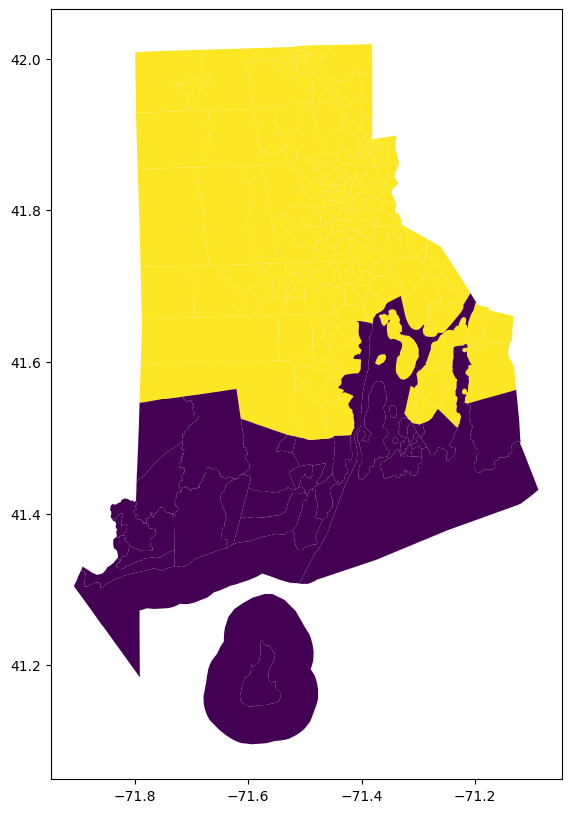

In [59]:
# RI Custom kmeans map
draw_map(districts=dist,k=2)

In [25]:
# state = "AR"
# filename = state + "_tracts"
# #read files for graph
# edges = read_edges('{}.dimacs'.format(filename))
# total_population, population = read_population('{}.population'.format(filename))
# geoids = read_geoids('{}.hash'.format(filename))

# k = read_num_districts('{}.dimacs'.format(filename))  # desired number of districts
# dists = read_dists('{}_distances.csv'.format(filename))
# #populate graph
# G=nx.Graph()

# for (node, pop), (_, geoid) in zip(population, geoids):
#   G.add_node(node, TOTPOP = pop, GEOID20 = geoid, DISTR = None)

# #G.nodes gives a list of nodes
# #for every node, node['TOTPOP'] gives population
# #                node['GEOID20'] gives geoid20
# #                node['DISTR'] gives assigned district
# #edges are not weighted
# #all distances are in dists
# G.add_edges_from(edges)

In [26]:
# edges = read_matrix('/Users/sarpgol/Desktop/Optimization/opt_project/Repo/optimization-group7/AR_tracts_distances.csv')

# #print(edges)
# total_population, population = read_population('/Users/sarpgol/Desktop/Optimization/opt_project/Repo/optimization-group7/AR_tracts.population')
# G = Graph()
# G.add_weighted_edges_from(edges)
# for (node, pop) in population:
#     #print(node)
#     G.nodes[node]['pop'] = pop
#     G.nodes[node]['name'] = node
# adj_matrix = nx.to_numpy_array(G=G)
# populations = np.array([G.nodes[node]['TOTPOP'] for node in G.nodes])

In [27]:
# # Custom Kmeans on AR
# n_clusters_AR =4
# pop_kmeans = np.array([(i,G.nodes[node]['TOTPOP']) for i,node in enumerate(G.nodes)])
# custom_kmeans = CustomKMeans(n_clusters=n_clusters_AR, random_state=0,penalty_weight=0.5,max_iter=500)
# dist = custom_kmeans.fit(adj_matrix, pop_kmeans)

In [28]:
# draw_map(districts=dist,k=k)

In [29]:
class CustomKMeans_upt:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, population):
        np.random.seed(self.random_state)
        # Initialize cluster centroids randomly
        centroids_indices = np.random.choice(len(population), self.n_clusters, replace=False)
        self.centroids = np.array([population[i][1] for i in centroids_indices])
        self.labels = np.zeros(len(population))
        self.old_labels = np.ones(len(population))

        for _ in range(self.max_iter):
            self.old_labels[:] = self.labels
            self.update_labels(population)
            self.update_centroids(population)

            # Check for convergence
            if np.all(self.labels == self.old_labels):
                break

        # Calculate total population per cluster
        cluster_populations = [np.sum([pop[1] for i, pop in enumerate(population) if self.labels[i] == c]) for c in range(self.n_clusters)]
        print("Total population per cluster:", cluster_populations)

        districts = []
        # Print nodes for each cluster
        for c in range(self.n_clusters):
            cluster_nodes = [i for i, pop in enumerate(population) if self.labels[i] == c]
            print("Nodes in Cluster {}: {}".format(c+1, cluster_nodes))
            districts.append(cluster_nodes)
        return districts

    def update_labels(self, population):
        # Update cluster labels based on population difference
        for i, pop in enumerate(population):
            self.labels[i] = np.argmin(np.abs(self.centroids - pop[1]))
            
    def update_centroids(self, population):
        # Update cluster centroids by taking the mean of the points in each cluster
        for c in range(self.n_clusters):
            cluster_points = [pop[1] for i, pop in enumerate(population) if self.labels[i] == c]
            
            if len(cluster_points) > 0:
                self.centroids[c] = np.mean(cluster_points, axis=0)





In [30]:
state = "AR"
filename = state + "_tracts"
#read files for graph
edges = read_edges('{}.dimacs'.format(filename))
total_population, population = read_population('{}.population'.format(filename))
geoids = read_geoids('{}.hash'.format(filename))

k = read_num_districts('{}.dimacs'.format(filename))  # desired number of districts
dists = read_dists('{}_distances.csv'.format(filename))
#populate graph
G=nx.Graph()

for (node, pop), (_, geoid) in zip(population, geoids):
  G.add_node(node, TOTPOP = pop, GEOID20 = geoid, DISTR = None)

#G.nodes gives a list of nodes
#for every node, node['TOTPOP'] gives population
#                node['GEOID20'] gives geoid20
#                node['DISTR'] gives assigned district
#edges are not weighted
#all distances are in dists
G.add_edges_from(edges)

In [42]:
print(dists[7])

[352, 367, 320, 352, 350, 365, 34, 0, 16, 277, 275, 256, 260, 260, 253, 255, 259, 178, 192, 321, 336, 326, 312, 277, 268, 247, 284, 257, 110, 180, 208, 180, 263, 262, 18, 18, 115, 262, 349, 334, 347, 353, 116, 116, 120, 398, 290, 287, 279, 291, 336, 235, 266, 269, 266, 263, 269, 262, 264, 265, 263, 259, 395, 396, 342, 342, 21, 339, 340, 264, 258, 256, 262, 269, 259, 254, 263, 261, 250, 254, 261, 262, 249, 254, 258, 258, 247, 259, 250, 256, 391, 391, 397, 389, 405, 206, 212, 248, 38, 17, 256, 259, 246, 238, 110, 120, 220, 234, 211, 233, 221, 110, 106, 167, 174, 167, 183, 396, 378, 408, 405, 127, 122, 116, 137, 121, 118, 101, 99, 110, 281, 275, 261, 257, 77, 51, 304, 289, 297, 285, 268, 263, 267, 262, 253, 266, 259, 270, 272, 267, 235, 285, 265, 240, 276, 283, 393, 397, 374, 376, 239, 229, 263, 267, 264, 264, 261, 348, 361, 50, 58, 49, 40, 45, 56, 53, 48, 48, 39, 53, 46, 56, 34, 43, 45, 58, 44, 52, 49, 44, 44, 48, 42, 36, 37, 47, 37, 39, 34, 35, 48, 47, 33, 40, 45, 38, 40, 45, 48, 48, 46

In [31]:
# Custom Kmeans on AR
n_clusters_AR =4
pop_kmeans = np.array([(i,G.nodes[node]['TOTPOP']) for i,node in enumerate(G.nodes)])
custom_kmeans = CustomKMeans_upt(n_clusters=n_clusters_AR, random_state=0,max_iter=500)
dist = custom_kmeans.fit(dists)

Total population per cluster: [53179, 10747, 89322, 38317]
Nodes in Cluster 1: [9, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 25, 29, 30, 31, 32, 33, 37, 52, 55, 57, 59, 60, 61, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 95, 96, 97, 130, 131, 132, 133, 136, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 162, 163, 164, 165, 166, 215, 216, 218, 219, 237, 255, 256, 257, 258, 259, 260, 268, 269, 270, 275, 276, 277, 286, 287, 293, 307, 309, 310, 311, 312, 315, 317, 318, 319, 320, 338, 380, 381, 384, 385, 386, 387, 388, 389, 390, 392, 393, 397, 399, 400, 401, 406, 409, 434, 435, 440, 452, 458, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 486, 487, 488, 491, 492, 493, 494, 495, 496, 497, 498, 505, 506, 507, 508, 517, 518, 519, 520, 558, 559, 568, 569, 570, 571, 588, 607, 621, 622, 623, 624, 625, 626, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644, 645, 646, 647, 648, 649,

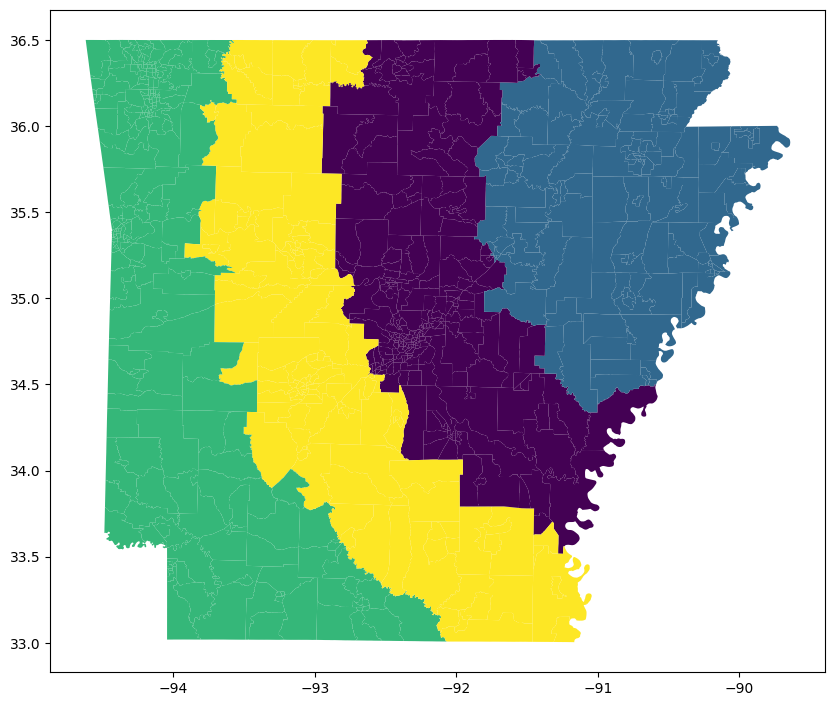

In [32]:
draw_map(districts=dist,k=n_clusters_AR)